In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(
    style="whitegrid",
    font_scale=2
);

# 0. Data loading <a class="anchor" id="section_1"></a>

In [2]:
DATA_FOLDER = Path('./data')
FRAME_LENGTH = 30
classes = [f.name for f in DATA_FOLDER.iterdir()]
classes

['running', 'stairs', 'walking', 'idle']

In [17]:
x_acc_cols = [f'acc_x_{i}' for i in range(FRAME_LENGTH)]
y_acc_cols = [f'acc_y_{i}' for i in range(FRAME_LENGTH)]
z_acc_cols = [f'acc_z_{i}' for i in range(FRAME_LENGTH)]
m_acc_cols = [f'acc_m_{i}' for i in range(FRAME_LENGTH)] # magnitude

frames = []
labels = []

for class_name in classes:
    class_folder = DATA_FOLDER / class_name
    for file in class_folder.iterdir():
        df = pd.read_csv(file)
        flat_frame = np.hstack([df['accelerometer_X'], df['accelerometer_Y'], df['accelerometer_Z']]).astype(float)
        frames.append(flat_frame)
        labels.append(class_name)
        
raw_data = pd.DataFrame(frames, columns = x_acc_cols+y_acc_cols+z_acc_cols)
raw_data = pd.concat([raw_data, pd.Series(labels, name='label')], axis=1)
raw_data.head(3)

,acc_x_0,acc_x_1,acc_x_2,acc_x_3,acc_x_4,acc_x_5,acc_x_6,acc_x_7,acc_x_8,acc_x_9,...,acc_z_21,acc_z_22,acc_z_23,acc_z_24,acc_z_25,acc_z_26,acc_z_27,acc_z_28,acc_z_29,label
0,2.667141,4.017470,22.357056,17.922995,-2.164358,9.749189,3.303998,-3.275268,5.252879,21.490355,...,13.493721,-2.001553,16.668432,9.208099,-7.187393,12.430696,-8.939949,1.470040,10.807426,running
1,10.745177,3.744532,0.766145,23.956383,-0.454898,-3.481169,3.572149,7.527370,-10.793061,9.481039,...,11.468226,-0.952892,-0.943315,-0.416591,0.483629,0.363919,1.699883,3.390190,-1.407790,running
2,22.031445,3.600880,-0.354342,8.245631,18.641254,4.381389,26.499025,4.003105,3.284845,2.231396,...,0.565032,-4.079719,-3.677494,4.596867,-0.550666,-6.019023,-1.139640,-2.164358,-3.016694,running


In [4]:
raw_data.shape

(6462, 91)

In [156]:
raw_data['label'].value_counts()

running    3408
walking    1850
idle       1039
stairs      165
Name: label, dtype: int64

In [157]:
165/6462

0.0255338904363974

# 2. Setup validation and baselines 

## 2.1 StratifiedKFold

In [5]:
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [6]:
X = raw_data['acc_x_0']
y = raw_data['label']

for i, (_, valid_ix) in enumerate(kfold.split(X, y)):
    y_valid = y.loc[valid_ix]
    value_counts = y_valid.value_counts()
    print(f'split#{i}, we have {value_counts.stairs} stairs, {value_counts.running} running samples')
#     print(    (y_valid == 'stairs').index)

split#0, we have 33 stairs, 682 running samples
split#1, we have 33 stairs, 682 running samples
split#2, we have 33 stairs, 682 running samples
split#3, we have 33 stairs, 681 running samples
split#4, we have 33 stairs, 681 running samples


TODO

In [16]:
raw_data.head()

,acc_x_0,acc_x_1,acc_x_2,acc_x_3,acc_x_4,acc_x_5,acc_x_6,acc_x_7,acc_x_8,acc_x_9,...,acc_m_20,acc_m_21,acc_m_22,acc_m_23,acc_m_24,acc_m_25,acc_m_26,acc_m_27,acc_m_28,acc_m_29
0,2.667141,4.017470,22.357056,17.922995,-2.164358,9.749189,3.303998,-3.275268,5.252879,21.490355,...,16.021034,28.484670,6.329056,36.200348,17.993455,12.013191,17.492539,14.443969,16.981173,12.873582
1,10.745177,3.744532,0.766145,23.956383,-0.454898,-3.481169,3.572149,7.527370,-10.793061,9.481039,...,9.027454,32.717137,12.632721,12.662257,12.112275,8.495985,13.047865,15.947642,35.383581,4.619655
2,22.031445,3.600880,-0.354342,8.245631,18.641254,4.381389,26.499025,4.003105,3.284845,2.231396,...,38.525506,8.434238,16.840514,5.681142,11.807488,9.724319,36.491155,24.877598,14.710831,10.426676
3,10.371682,25.718515,-3.600879,10.534488,6.737284,-3.203442,7.077260,18.650831,1.000776,5.506664,...,19.355728,15.286692,17.733111,48.628484,5.166496,7.544442,11.115634,41.425569,11.983671,15.710840
4,3.624822,33.073500,3.792416,-1.872266,-4.070143,8.643068,6.627151,16.864758,23.654713,-1.843535,...,31.329266,16.592405,16.973815,16.455020,9.877598,14.735752,39.712567,13.270762,15.094665,18.892170


# Feature generation

In [18]:
# Step 1: Am
am_matrix = np.sqrt(raw_data[x_acc_cols].values**2 + raw_data[y_acc_cols].values**2 + raw_data[z_acc_cols].values**2)

In [23]:
am_matrix.shape

(6462, 30)

In [34]:
y_readable = raw_data['label']

In [25]:
# time series matrix
ts_matrix = np.stack([raw_data[x_acc_cols], raw_data[y_acc_cols], raw_data[z_acc_cols], am_matrix], axis=1)
ts_matrix.shape

(6462, 4, 30)

In [31]:
ts_ax_names = ['x', 'y', 'z', 'm']
assert len(ts_ax_names) == ts_matrix.shape[1]

In [36]:
mean_features = pd.DataFrame(ts_matrix.mean(axis=2), columns=[f'mean_{ax}' for ax in ts_ax_names])
mean_features.head()

,mean_x,mean_y,mean_z,mean_m
0,6.337292,8.498299,1.258712,15.624797
1,4.289133,7.908048,3.308148,16.132500
2,7.431443,7.043741,0.303425,17.820819
3,7.091466,8.317776,-1.056960,17.497574
4,6.021896,7.919062,0.871809,19.284301


In [39]:
minmax_m = ts_matrix.max(axis=2) - ts_matrix.min(axis=2)
minmax_features = pd.DataFrame(minmax_m, columns=[f'minmax_{ax}' for ax in ts_ax_names])
minmax_features.head()

,mean_x,mean_y,mean_z,mean_m
0,25.632324,38.288073,26.216509,32.512064
1,34.749444,48.520891,25.091234,43.707757
2,32.953793,43.909660,18.579005,33.142113
3,36.956896,50.637368,27.705703,43.461989
4,41.079710,53.141701,25.843013,41.235884


In [40]:
std_m = ts_matrix.std(axis=2)
std_features = pd.DataFrame(std_m, columns=[f'std_{ax}' for ax in ts_ax_names])
std_features.head()

,std_x,std_y,std_z,std_m
0,7.564228,10.244186,6.601717,8.693446
1,7.902334,13.691003,5.786178,10.723361
2,9.556435,13.968923,4.729323,9.806827
3,9.365268,14.103110,5.036472,11.242702
4,10.586884,15.815222,5.179406,10.811114


In [69]:
min_m = ts_matrix.min(axis=2)
min_features = pd.DataFrame(min_m, columns=[f'min_{ax}' for ax in ts_ax_names])
min_features.head()

,min_x,min_y,min_z,min_m
0,-3.275268,-8.762778,-9.548077,4.968120
1,-10.793061,-12.622231,-3.945644,1.000135
2,-4.697424,-16.749836,-7.254431,5.681142
3,-7.105990,-13.306973,-15.318103,5.166496
4,-8.006210,-19.938911,-16.376339,5.874076


In [47]:
rms_m = np.sqrt(np.square(ts_matrix).mean(axis=2))
rms_features = pd.DataFrame(rms_m, columns=[f'rms_{ax}' for ax in ts_ax_names])
rms_features.head()

,rms_x,rms_y,rms_z,rms_m
0,9.868071,13.310313,6.720642,17.880444
1,8.991304,15.810781,6.665111,19.371320
2,12.105857,15.644332,4.739047,20.340980
3,11.747218,16.373243,5.146185,20.798160
4,12.179710,17.687080,5.252266,22.108018


In [ ]:
ix = np.arange(len(ts_matrix))
iy = ix + len(ts_matrix)

In [65]:
corr_xy = np.corrcoef(ts_matrix[:, 0, :], ts_matrix[:, 1, :])[ix,iy]
corr_yz = np.corrcoef(ts_matrix[:, 1, :], ts_matrix[:, 2, :])[ix,iy]
corr_xz = np.corrcoef(ts_matrix[:, 0, :], ts_matrix[:, 2, :])[ix,iy]

In [68]:
corr_features = pd.DataFrame({'corr_xy': corr_xy, 'corr_yz': corr_yz, 'corr_xz': corr_xz})
corr_features.head()

,corr_xy,corr_yz,corr_xz
0,0.430846,0.668644,0.232428
1,0.465562,0.359810,0.123989
2,0.592725,0.446544,0.272770
3,0.555891,0.161760,-0.146196
4,0.574375,0.141424,-0.355399


# Clean feature extraction

In [75]:
def extract_features(x_part, y_part, z_part):
    magnitude_part = np.sqrt(x_part**2 + y_part**2 + z_part**2)
    ts_matrix = np.stack([x_part, y_part, z_part, magnitude_part], axis=1)
    ts_ax_names = ['x', 'y', 'z', 'm']
    assert len(ts_ax_names) == ts_matrix.shape[1]
    
    mean_features = pd.DataFrame(ts_matrix.mean(axis=2), columns=[f'mean_{ax}' for ax in ts_ax_names])
    
    minmax_m = ts_matrix.max(axis=2) - ts_matrix.min(axis=2)
    minmax_features = pd.DataFrame(minmax_m, columns=[f'minmax_{ax}' for ax in ts_ax_names])
    
    std_m = ts_matrix.std(axis=2)
    std_features = pd.DataFrame(std_m, columns=[f'std_{ax}' for ax in ts_ax_names])
    
    min_m = ts_matrix.min(axis=2)
    min_features = pd.DataFrame(min_m, columns=[f'min_{ax}' for ax in ts_ax_names])
    
    rms_m = np.sqrt(np.square(ts_matrix).mean(axis=2))
    rms_features = pd.DataFrame(rms_m, columns=[f'rms_{ax}' for ax in ts_ax_names])
    
    ix = np.arange(len(ts_matrix))
    iy = ix + len(ts_matrix)
    corr_xy = np.corrcoef(ts_matrix[:, 0, :], ts_matrix[:, 1, :])[ix,iy]
    corr_yz = np.corrcoef(ts_matrix[:, 1, :], ts_matrix[:, 2, :])[ix,iy]
    corr_xz = np.corrcoef(ts_matrix[:, 0, :], ts_matrix[:, 2, :])[ix,iy]
    corr_features = pd.DataFrame({'corr_xy': corr_xy, 'corr_yz': corr_yz, 'corr_xz': corr_xz})
    
    features = pd.concat([mean_features, minmax_features, min_features, rms_features, corr_features], axis=1)
    return features

In [76]:
feature_df = extract_features(
    raw_data[x_acc_cols].values,
    raw_data[y_acc_cols].values,
    raw_data[z_acc_cols].values)

In [78]:
feature_df.shape

(6462, 19)

In [83]:
from sklearn import preprocessing
target_le = preprocessing.LabelEncoder()
target_le.fit(classes)

LabelEncoder()

In [84]:
feature_df['label'] = target_le.transform(raw_data['label'])

In [85]:
feature_df.shape

(6462, 20)

In [86]:
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix, accuracy_score

In [161]:
f1_score([1, 2, 3], [3, 2, 1], average=None).mean()

0.3333333333333333

array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.78787879, 0.21212121],
       [0.        , 0.        , 0.00540541, 0.99459459]])

In [177]:
numerical_metrics = ['accuracy', 'f1_macro', 'f1_min']

def evaluate_performance(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_min': f1_score(y_true, y_pred, average=None).min(),
        'CM': confusion_matrix(y_valid, y_pred, normalize='true'),
        'CM_not_normalized': confusion_matrix(y_valid, y_pred),
    }
    
    return metrics

        accuracy    f1_macro     f1_min
mean    0.978489    0.862823    0.49035
std   0.00253573  0.00561759  0.0221213


In [ ]:
print_df = 

In [178]:
df.mean()

accuracy    0.978489
f1_macro    0.862823
f1_min       0.49035
dtype: object

In [210]:
# C_ij - i is true, predicted in j
cm = df['CM'].values.mean()
cm

array([[1.        , 0.        , 0.        , 0.        ],
       [0.00176082, 0.99823918, 0.        , 0.        ],
       [0.        , 0.        , 0.38787879, 0.61212121],
       [0.        , 0.        , 0.0172973 , 0.9827027 ]])

In [241]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.3)
    labels_ordered = target_encoder.inverse_transform(range(4))
    sns.heatmap(cm, annot=True, fmt='.1%', cmap='Blues', cbar=False, xticklabels=labels_ordered, yticklabels=labels_ordered)
    plt.xlabel('predicted')
    plt.ylabel('actual');

In [242]:
def print_cv_metrics(cv_metrics):
    df = pd.DataFrame(cv_metrics)
    print_df = pd.concat([df.mean()[numerical_metrics], df.std()[numerical_metrics]], axis=1)
    print_df.columns = ['mean', 'std']
    print(print_df.T)
    cm = df['CM'].values.mean()
    plot_confusion_matrix(cm)

        accuracy    f1_macro     f1_min
mean    0.978489    0.862823    0.49035
std   0.00253573  0.00561759  0.0221213


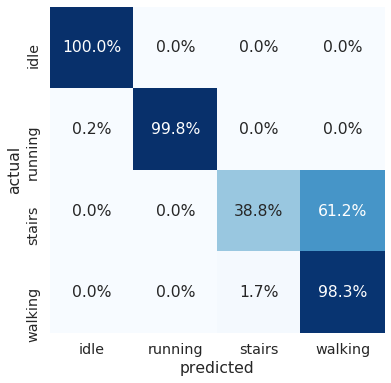

In [244]:
print_cv_metrics(cv_metrics)

In [171]:
X = feature_df[['mean_x', 'mean_y', 'mean_z']]
y = feature_df['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = linear_model.LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])


[[208   0   0   0]
 [  3 679   0   0]
 [  0   0  13  20]
 [  0   0   5 365]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  11  22]
 [  0   0   2 368]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  12  21]
 [  0   0   6 364]]
[[208   0   0   0]
 [  2 679   0   0]
 [  0   0  14  19]
 [  0   0  12 358]]
[[208   0   0   0]
 [  1 680   0   0]
 [  0   0  14  19]
 [  0   0   7 363]]


In [91]:
all_features = [c for c in feature_df.columns if c != 'label']
all_features

['mean_x',
 'mean_y',
 'mean_z',
 'mean_m',
 'minmax_x',
 'minmax_y',
 'minmax_z',
 'minmax_m',
 'min_x',
 'min_y',
 'min_z',
 'min_m',
 'rms_x',
 'rms_y',
 'rms_z',
 'rms_m',
 'corr_xy',
 'corr_yz',
 'corr_xz']

In [92]:
X = feature_df[all_features]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = linear_model.LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(accuracy_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'Accuracy mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  23  10]
 [  0   0   2 368]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  29   4]
 [  0   0   9 361]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  26   7]
 [  0   0   3 367]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  23  10]
 [  0   0   4 366]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  29   4]
 [  0   0   2 368]]
Accuracy mean: 0.99, std: 0.0


In [147]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

"""Инициализируем класс, который выполняет преобразование"""
transform = PolynomialFeatures(2, include_bias=False)

In [148]:
X = transform.fit_transform(feature_df[all_features])
y = feature_df['label'].values
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X[train_ix], X[valid_ix]
    y_train, y_valid = y[train_ix], y[valid_ix]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    cls = linear_model.LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(accuracy_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'Accuracy mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  28   5]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  33   0]
 [  0   0   3 367]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  31   2]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  29   4]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  32   1]
 [  0   0   0 370]]
Accuracy mean: 1.0, std: 0.0


In [149]:
X_train.shape

(5170, 209)

In [150]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
cls = linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=.1)
cls.fit(X_train, y_train)
y_pred = cls.predict(X_valid)
confusion_matrix(y_pred, y_valid)

array([[208,   0,   0,   0],
       [  0, 681,   0,   0],
       [  0,   0,  26,   2],
       [  0,   0,   7, 368]])

In [151]:
cls.coef_.shape

(4, 209)

In [154]:
len([(feature_name, score) for feature_name, score in list(zip(transform.get_feature_names(all_features), cls.coef_.min(axis=0))) if np.abs(score) < 1e-5])

172

In [155]:
209 - 172

37

In [112]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
cls = linear_model.LogisticRegression(solver='liblinear', penalty='l1')
cls.fit(X_train, y_train)


In [113]:
confusion_matrix(y_pred, y_valid)

array([[208,   0,   0,   0],
       [  0, 681,   0,   0],
       [  0,   0,  29,   4],
       [  0,   0,   4, 366]])

In [115]:
X_train.shape

(5170, 19)

In [119]:
cls.coef_.shape

(4, 19)

array([-5.44600762, -9.75175713, -5.3422712 , -0.34121835, -1.60088442,
       -1.76696115, -1.01441776, -0.95303517, -0.49234904, -0.83559681,
       -0.8449462 , -1.73906215, -2.96130259, -1.11790575, -1.7654351 ,
       -6.18761231, -1.31172606, -1.24290891, -0.21264137])

In [121]:
list(zip(all_features, ))

[('mean_x', -5.4460076176709205),
 ('mean_y', -9.751757125669487),
 ('mean_z', -5.342271200759968),
 ('mean_m', -0.3412183516395128),
 ('minmax_x', -1.600884418050687),
 ('minmax_y', -1.7669611510845873),
 ('minmax_z', -1.0144177592798787),
 ('minmax_m', -0.9530351712833459),
 ('min_x', -0.4923490412471908),
 ('min_y', -0.8355968089499377),
 ('min_z', -0.8449462005092604),
 ('min_m', -1.7390621510442512),
 ('rms_x', -2.9613025865129377),
 ('rms_y', -1.117905752189049),
 ('rms_z', -1.765435100250287),
 ('rms_m', -6.187612308092692),
 ('corr_xy', -1.311726057945506),
 ('corr_yz', -1.2429089140381602),
 ('corr_xz', -0.21264137345022988)]

In [93]:
from sklearn.ensemble import RandomForestClassifier

In [94]:
X = feature_df[all_features]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = RandomForestClassifier()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(accuracy_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'Accuracy mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  31   2]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  33   0]
 [  0   0   0 370]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  30   3]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  33   0]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  30   3]
 [  0   0   0 370]]
Accuracy mean: 1.0, std: 0.0


In [29]:
cls = linear_model.LogisticRegression(max_iter=2_000)
cls.fit(X_train, y_train)
y_pred = cls.predict(X_valid)

In [30]:
cls.coef_

array([[-1.11693219,  1.26996541,  2.64989393],
       [ 0.8761829 ,  0.48161475, -0.95354791],
       [ 0.52349184, -0.55169286, -1.38645113],
       [-0.28274254, -1.19988731, -0.30989489]])

In [27]:
mean_features

['mean_x', 'mean_y', 'mean_z', 'mean_m']

Feature engineering